In [17]:
import os
from dotenv import load_dotenv
from datetime import datetime

load_dotenv()

os.environ["GOOGLE_API_KEY"] = os.getenv("GEMINI_API_KEY")

from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")

In [18]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph import add_messages

class State(TypedDict):
    # Messages have the type list. The add_messages function
    # in the annotation defines how this state key should be updated
    # in this case it appends the list rather than overwriting them
    messages:Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [19]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from tavily import TavilyClient
from langchain_core.messages import SystemMessage

wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(doc_content_chars_max=10000000))
tavily_client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))

def wikipedia_tool(query: str)->str:
    """Goes to wikipedia and searches for the query
    Args: 
        query (str): querey to search for 
    Returns:
        str: The result of the search
    """
    wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(doc_content_chars_max=10000000))
    return wikipedia.run(query)

def tavily_tool(query:str) -> str:
    """
    Goes to tavily search and searches for the query and gives the detailed content
    Args:
        query (str): querey to search for 
    Returns:
        str: The result of the search
        
    """
    response = tavily_client.search(query)
    content = ""
    for i in response['results']:
        content += i['content']
    return content

llm_with_wikipedia_tool = llm.bind_tools([wikipedia_tool])
llm_with_tavily_tool = llm.bind_tools([tavily_tool])


sys_msg_wikipedia = SystemMessage(content="You are a helpful assistant that breaks down the query into a key word and searches wikipedia for the key word")
sys_msg_tavily = SystemMessage(content="You are a helpful assistant that breaks down the quert into a key word and searches tavily for the key word")
sys_msg_summarize = SystemMessage(content="You are a helpful assistant that summarizes the content given to you")

#Define nodes
def wikipedia_llm(state: State):
    return {"messages": [llm_with_wikipedia_tool.invoke([sys_msg_wikipedia] + state["messages"])]}

def tavily_llm(state:State):
    return {"messages": [llm_with_tavily_tool.invoke([sys_msg_tavily] + state["messages"])]}

def summarize_llm(state:State):
    """Summarizes the wikipedia content"""
    return {"messages": [llm.invoke([sys_msg_summarize] + state["messages"])]}


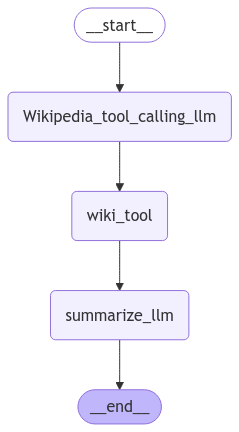

In [ ]:
## Define Graph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode


graph_builder = StateGraph(State)
graph_builder.add_node("Wikipedia_tool_calling_llm", wikipedia_llm)
## forcing llm to use wikipedia tool
graph_builder.add_node("wiki_tool",ToolNode([wikipedia_tool]))
graph_builder.add_node("summarize_llm",summarize_llm)

graph_builder.add_edge(START,"Wikipedia_tool_calling_llm")
graph_builder.add_edge("Wikipedia_tool_calling_llm","wiki_tool")
graph_builder.add_edge("wiki_tool","summarize_llm")
graph_builder.add_edge("summarize_llm",END)

graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
from langchain_core.messages import HumanMessage
messages = graph.invoke({"messages": [HumanMessage(content="Indian Food")]})

messages

{'messages': [HumanMessage(content='Indian Food', additional_kwargs={}, response_metadata={}, id='2361b701-9330-4a63-98ee-40a0dbbf511c'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'wikipedia_tool', 'arguments': '{"query": "Indian Food"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-538e2f9b-9450-4e48-8ae5-098c7f104cdc-0', tool_calls=[{'name': 'wikipedia_tool', 'args': {'query': 'Indian Food'}, 'id': '7bd6c81d-0d12-4e1a-aa36-7f4361088b26', 'type': 'tool_call'}], usage_metadata={'input_tokens': 64, 'output_tokens': 6, 'total_tokens': 70, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='Page: Indian cuisine\nSummary: Indian cuisine consists of a variety of regional and traditional cuisines native to the Indian subcontinent. Given the diversity in soil, climate, culture, ethnic groups, and occupations, these cuisines vary substantially and use locally 

In [25]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Indian Food
================================== Ai Message ==================================
Tool Calls:
  wikipedia_tool (7bd6c81d-0d12-4e1a-aa36-7f4361088b26)
 Call ID: 7bd6c81d-0d12-4e1a-aa36-7f4361088b26
  Args:
    query: Indian Food
================================= Tool Message =================================
Name: wikipedia_tool

Page: Indian cuisine
Summary: Indian cuisine consists of a variety of regional and traditional cuisines native to the Indian subcontinent. Given the diversity in soil, climate, culture, ethnic groups, and occupations, these cuisines vary substantially and use locally available spices, herbs, vegetables, and fruits.
Indian food is also heavily influenced by religion, in particular Hinduism and Islam, cultural choices and traditions. Historical events such as invasions, trade relations, and colonialism have played a role in introducing certain foods to India. The Columbia